In [1]:
import numpy as np 
import plotly.graph_objects as go
from matplotlib import pyplot as plt
from jax import numpy as jnp
import jax 
import diffrax 
import optax

In [2]:
# helper functions 

def F(theta): 
    return (1 + 3/2*jnp.cos(theta) - 1/2*(jnp.cos(theta))**3)**(1/3)

def Delta(theta, phi): 
    return jnp.clip(jnp.sin(theta) - F(theta)*jnp.cos(phi), 1e-5, None)

def D(theta, phi): 
    return F(theta)*jnp.sin(phi) 

def R_tilde(theta, phi): 
    return (D(theta, phi)**2 + Delta(theta, phi)**2)/(2*Delta(theta, phi))

def psi(theta, phi): 
    return jnp.arcsin(D(theta, phi)/R_tilde(theta, phi))

def zeta(theta, phi): 
    return 2*psi(theta, phi)*R_tilde(theta, phi)/F(theta)/np.pi 

def h(theta): 
    return jnp.sin(theta)/ F(theta)

def G(theta, phi, k): 
    term1 = (1+jnp.cos(theta))/F(theta)**2
    term2 = k*zeta(theta, phi) 
    return term1 + term2 

def total_energy(theta, phi, k):
    return G(theta, phi, k) - 2*phi/np.pi*k

dzeta_dtheta = jax.grad(zeta, argnums=0)
dzeta_dphi = jax.grad(zeta, argnums=1)
dG_dtheta = jax.grad(G, argnums=0)
dG_dphi = jax.grad(G, argnums=1)
dh_dtheta = jax.grad(h)

def dtheta_dt(theta, phi, params):
    k, Ta, l, phi_dot = params
    # a = Ta/2*( (1+jnp.cos(theta))*dh_dtheta(theta)**2 + l/zeta(theta, phi)*dzeta_dtheta(theta, phi)**2)
    # b = Ta*l/zeta(theta, phi)*dzeta_dtheta(theta, phi)*dzeta_dphi(theta, phi)*phi_dot + dG_dtheta(theta, phi, k) 
    # c = Ta/2*l/zeta(theta, phi)*(dzeta_dphi(theta, phi)*phi_dot)**2 + (dG_dphi(theta, phi, k) - 2*k/np.pi)*phi_dot 
    a = Ta/2*(1+jnp.cos(theta) + l*zeta(theta, phi)/h(theta)**2)*dh_dtheta(theta)**2
    b = dG_dtheta(theta, phi, k) 
    c = (dG_dphi(theta, phi, k) - 2*k/np.pi)*phi_dot*(1 - jnp.tanh(100*(phi-np.pi/2*0.9)))/2

    discriminant = b**2 - 4*a*c
    root1 = (-jnp.sqrt(discriminant) - b)/(2*a)
    root2 = (jnp.sqrt(discriminant) - b)/(2*a)
    desired_sign = -b
    return jnp.where(root1 * desired_sign > 0, root1, root2)

    # return (-jnp.sqrt(b**2- 4*a*c) - b)/(2*a)
    # return b**2- 4*a*c



(200,)
(200,)
(200,)


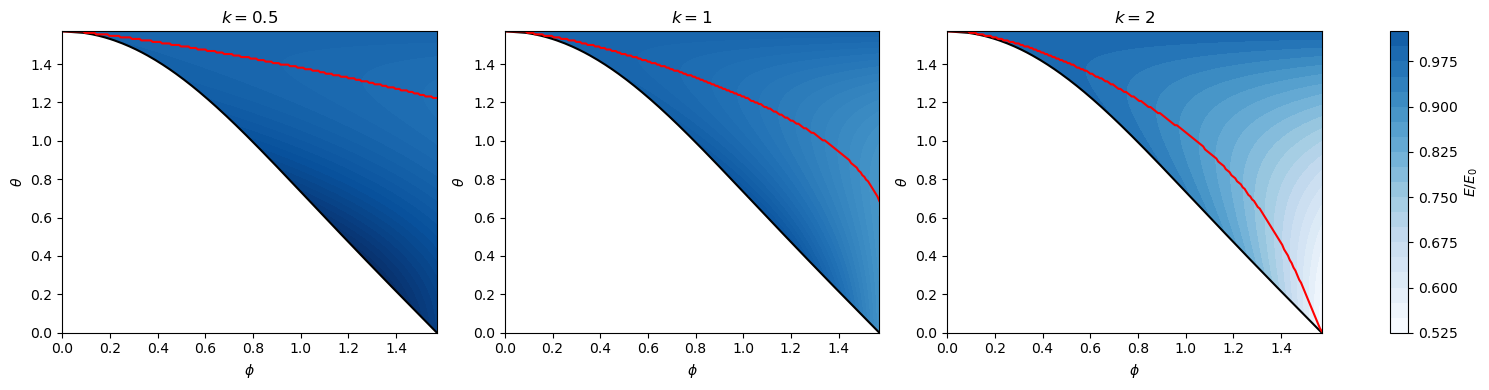

In [4]:
k_values = [0.5, 1, 2]

thetas = np.linspace(0, np.pi/2, 200)
phis = np.linspace(0, np.pi/2, 200)
x, y = np.meshgrid(phis, thetas)

fig = plt.figure(figsize=(15, 4))
gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, 1, 0.05])
axes = [fig.add_subplot(gs[0, i]) for i in range(3)]
cax = fig.add_subplot(gs[0, 3])

# Find global min/max for consistent colorbar
vmin = float('inf')
vmax = float('-inf')
for k in k_values:
    energy = np.array(total_energy(y, x, k))
    energy[x < np.arccos(np.sin(y)/F(y))] = np.nan
    vmin = np.minimum(vmin, np.nanmin(energy))
    vmax = np.maximum(vmax, np.nanmax(energy))

for i, k in enumerate(k_values):
    energy = np.array(total_energy(y, x, k))
    energy[x < np.arccos(np.sin(y)/F(y))] = np.nan
    min_indices = np.nanargmin(energy, axis=0)
    min_thetas = y[min_indices, np.arange(len(min_indices))] 

    print(min_thetas.shape)
    
    im = axes[i].contourf(x, y, energy, levels=20, cmap='Blues', vmin=vmin, vmax=vmax)
    axes[i].plot(np.arccos(np.sin(thetas)/F(thetas)), thetas, color='black')
    axes[i].plot(x[0], min_thetas, color='red')
    axes[i].set_xlabel(r'$\phi$')
    axes[i].set_ylabel(r'$\theta$')
    axes[i].set_title(rf'$k={k}$')

plt.colorbar(im, cax=cax, label=r'$E/E_0$')
plt.tight_layout()
plt.savefig('../figures/constriction.png', dpi=300)
plt.show()



In [5]:
# Define the loss function
def loss_fn(theta, k):
    return total_energy(theta, np.pi/2, k)

# Setup optimizer
optimizer = optax.adam(learning_rate=0.005)

def find_minimum_for_k_optax(k, steps=4000):
    # Initial parameters
    theta = np.pi/4 
    opt_state = optimizer.init(theta)
    
    # One step of optimization
    @jax.jit
    def step(theta, opt_state):
        loss_value, grads = jax.value_and_grad(loss_fn)(theta, k)
        updates, opt_state = optimizer.update(grads, opt_state)
        theta = optax.apply_updates(theta, updates)
        # Clip to bounds
        theta = jnp.clip(theta, 0, jnp.pi/2)
        return theta, opt_state, loss_value

    # Optimization loop
    for _ in range(steps):
        theta, opt_state, loss_value = step(theta, opt_state)
    
    return theta, loss_value

# Run optimization
k_values = jnp.arange(0, 2, 0.01)
results = jnp.array([find_minimum_for_k_optax(k) for k in k_values])


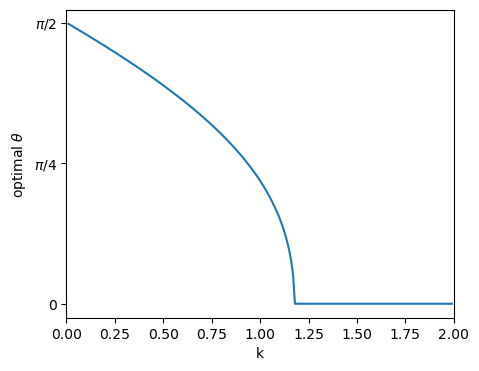

In [9]:
fig = plt.figure(figsize=(5, 4))

plt.plot(k_values, results[:, 0])
plt.xlabel('k')
plt.ylabel(r'optimal $\theta$')
plt.xlim([0, 2])
plt.yticks([0, np.pi/4, np.pi/2], ['0', r'$\pi/4$', r'$\pi/2$'])
plt.savefig('../figures/constriction_theta.pdf')
plt.show() 

In [10]:
# set up ode solver 
def rhs(t, theta, args):
    phi_dot = args[-1] 
    return dtheta_dt(theta, phi_dot*t, args)

term = diffrax.ODETerm(rhs)
solver = diffrax.Euler()  

def solve_ode(params, dt0=0.001, y0=np.pi/2, t0=0.1, t1=10):
    saveat = diffrax.SaveAt(ts=jnp.linspace(t0, t1, 500))

    # Solve
    solution = diffrax.diffeqsolve(
        term,
        solver,
        t0=t0,
        t1=t1,
        dt0=dt0,
        y0=y0,
        args=jnp.array(params), 
        saveat=saveat,
        max_steps=int((t1-t0)/dt0*2)
    )
    return solution 

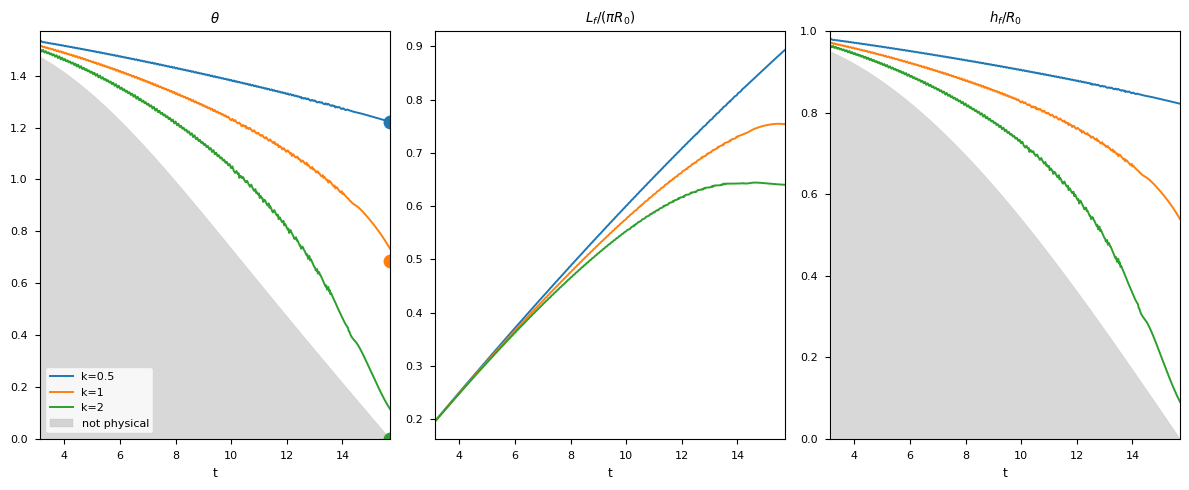

In [12]:
# Set up params 
Ta = 0.1
l = 0.1
phi_dot = 0.1
params = [k, Ta, l, phi_dot]

# set up simulation scope
t0 = np.pi/10/phi_dot
t1 = np.maximum(np.pi/2/phi_dot, Ta*10)
dt0 = np.minimum(Ta/10, phi_dot/10)

plt.style.use('seaborn-v0_8-paper')
fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharex=True)

for (i, k) in enumerate([0.5, 1, 2]):
    params[0] = k
    solution = solve_ode(params, dt0=dt0, t0=t0, t1=t1)
    ts = solution.ts[1:]  # time points
    ys = solution.ys[1:]  # solution at each time point
    line = axes[0].plot(ts, ys, '-', label=f'k={k}')
    axes[0].plot(ts[-1], results[int(k*100), 0], 'o', markersize=10, color=line[0].get_color())
    axes[1].plot(ts, zeta(ys, phi_dot*ts), '-', label=f'k={k}')
    axes[2].plot(ts, h(ys), '-', label=f'k={k}')


thetas = np.linspace(0, np.pi/2, 100)
axes[0].fill_between(np.arccos(np.sin(thetas)/F(thetas))/phi_dot,
                     thetas, color='grey', alpha=0.3, label='not physical')
hs = np.cos(ts*phi_dot)
axes[2].fill_between(ts, hs, color='grey', alpha=0.3, label='not physical')

axes[0].legend() 
axes[0].set_xlim([t0, t1])
axes[0].set_title(r'$\theta$')
axes[0].set_ylim([0, np.pi/2])
axes[2].set_ylim([0, 1])
axes[0].set_xlabel('t')
axes[1].set_xlabel('t')
axes[2].set_xlabel('t')
axes[1].set_title(r'$L_f/(\pi R_0)$')
axes[2].set_title(r'$h_f/R_0$')
plt.tight_layout() 
plt.savefig('../figures/dyn_constriction.pdf')
plt.show()